In [1]:
import pandas as pd

df = pd.read_csv( '../../../data_school_budget/school/TrainingData.csv' )



          Unnamed: 0            FTE         Total
count  400277.000000  126071.000000  3.957220e+05
mean   225186.018537       0.426794  1.310586e+04
std    130025.142718       0.573576  3.682254e+05
min         2.000000      -0.087551 -8.746631e+07
25%    112601.000000       0.000792  7.379770e+01
50%    225243.000000       0.130927  4.612300e+02
75%    337722.000000       1.000000  3.652662e+03
max    450340.000000      46.800000  1.297000e+08


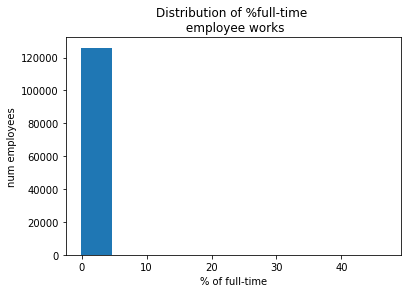

In [2]:
# Print the summary statistics
print(df.describe())

# Import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
# Create the histogram
_= plt.hist(df['FTE'].dropna())

# Add title and labels
plt.title('Distribution of %full-time \n employee works')
plt.xlabel('% of full-time')
plt.ylabel('num employees')

# Display the histogram
plt.show()

The high variance in expenditures makes sense (some purchases are cheap some are expensive). Also, it looks like the FTE column is bimodal. That is, there are some part-time and some full-time employees.

In [3]:
LABELS = ['Function',
 'Use',
 'Sharing',
 'Reporting',
 'Student_Type',
 'Position_Type',
 'Object_Type',
 'Pre_K',
 'Operating_Status']


# Define the lambda function: categorize_label
categorize_label = lambda x: x.astype('category')

# Convert df[LABELS] to a categorical type
df[LABELS] = df[LABELS].apply(categorize_label , axis =0)

# Print the converted dtypes
print(df[LABELS].dtypes)

Function            category
Use                 category
Sharing             category
Reporting           category
Student_Type        category
Position_Type       category
Object_Type         category
Pre_K               category
Operating_Status    category
dtype: object


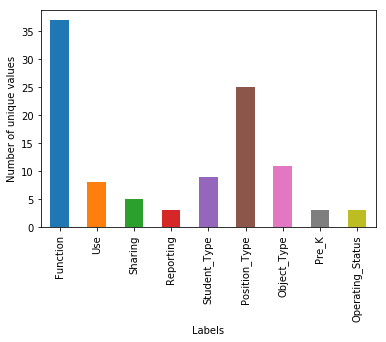

In [4]:
# Import matplotlib.pyplot
import matplotlib.pyplot as plt

# Calculate number of unique values for each label: num_unique_labels
num_unique_labels = df[LABELS].apply(  pd.Series.nunique ,  axis =0)

# Plot number of unique values for each label
num_unique_labels.plot( kind = 'bar' )

# Label the axes
plt.xlabel('Labels')
plt.ylabel('Number of unique values')

# Display the plot
plt.show()

In [5]:
from warnings import warn

import numpy as np
import pandas as pd

def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).any():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])


def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]


def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])

In [6]:
dummies = pd.get_dummies(  df[LABELS]   , prefix_sep = '_')

dummies.head(2)


,Function_Aides Compensation,Function_Career & Academic Counseling,Function_Communications,Function_Curriculum Development,Function_Data Processing & Information Services,Function_Development & Fundraising,Function_Enrichment,Function_Extended Time & Tutoring,Function_Facilities & Maintenance,Function_Facilities Planning,...,Object_Type_Rent/Utilities,Object_Type_Substitute Compensation,Object_Type_Supplies/Materials,Object_Type_Travel & Conferences,Pre_K_NO_LABEL,Pre_K_Non PreK,Pre_K_PreK,Operating_Status_Non-Operating,"Operating_Status_Operating, Not PreK-12",Operating_Status_PreK-12 Operating
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [7]:
# Create the new DataFrame: numeric_data_only
NUMERIC_COLUMNS = ['FTE', 'Total']
numeric_data_only = df[NUMERIC_COLUMNS].fillna(-1000)

# Get labels and convert to dummy variables: label_dummies
label_dummies = pd.get_dummies(df[LABELS] , prefix_sep = '_')

# Create training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_data_only, label_dummies  , size=0.2, seed= 123 )  
                                                    

# Print the info
print("X_train info:")
print(X_train.info())
print("\nX_test info:")  
print(X_test.info())
print("\ny_train info:")  
print(y_train.info())
print("\ny_test info:")  
print(y_test.info()) 

X_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 0 to 400276
Data columns (total 2 columns):
FTE      320222 non-null float64
Total    320222 non-null float64
dtypes: float64(2)
memory usage: 7.3 MB
None

X_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 4 to 400274
Data columns (total 2 columns):
FTE      80055 non-null float64
Total    80055 non-null float64
dtypes: float64(2)
memory usage: 1.8 MB
None

y_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 0 to 400276
Columns: 104 entries, Function_Aides Compensation to Operating_Status_PreK-12 Operating
dtypes: uint8(104)
memory usage: 34.2 MB
None

y_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 4 to 400274
Columns: 104 entries, Function_Aides Compensation to Operating_Status_PreK-12 Operating
dtypes: uint8(104)
memory usage: 8.6 MB
None


In [8]:
# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Create the DataFrame: numeric_data_only
numeric_data_only = df[NUMERIC_COLUMNS].fillna(-1000)

# Get labels and convert to dummy variables: label_dummies
label_dummies = pd.get_dummies(df[LABELS])

# Create training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_data_only,
                                                               label_dummies,
                                                               size=0.2, 
                                                               seed=123)

# Instantiate the classifier: clf
clf = OneVsRestClassifier( LogisticRegression() )

# Fit the classifier to the training data
clf.fit(X_train , y_train)

# Print the accuracy
print("Accuracy: {}".format(clf.score(X_test
, y_test)))

Accuracy: 0.0


The good news is that your workflow didn't cause any errors. The bad news is that your model scored the lowest possible accuracy: 0.0! But hey, you just threw away ALL of the text data in the budget. Later, you won't. Before you add the text data, let's see how the model does when scored by log loss.

In [9]:
# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression())

# Fit it to the training data
clf.fit(X_train, y_train)

# Load the holdout data: holdout
holdout = pd.read_csv( '../../../data_school_budget/school/TestData.csv'  , index_col = 0 )

# Generate predictions: predictions
predictions = clf.predict_proba(holdout[NUMERIC_COLUMNS].fillna(-1000))

/home/deepanshu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
# Generate predictions: predictions


# Format predictions in DataFrame: prediction_df
prediction_df = pd.DataFrame(columns=
                          pd.get_dummies(df[LABELS]).columns,
                             index=holdout.index,
                             data=predictions)


# Save prediction_df to csv
#prediction_df.to_csv('predictions.csv')

# # Submit the predictions for scoring: score
# score = score_submission( pred_path='predictions.csv' )

# # Print score
# print('Your model, trained with numeric data only, yields logloss score: {}'.format(score))

Creating a bag-of-words in scikit-learn

In this exercise, you'll study the effects of tokenizing in different ways by comparing the bag-of-words representations resulting from different token patterns.

You will focus on one feature only, the Position_Extra column, which describes any additional information not captured by the Position_Type label.

For example, in the Shell you can check out the budget item in row 8960 of the data using df.loc[8960]. Looking at the output reveals that this Object_Description is overtime pay. For who? The Position Type is merely "other", but the Position Extra elaborates: "BUS DRIVER". Explore the column further to see more instances. It has a lot of NaN values.

Your task is to turn the raw text in this column into a bag-of-words representation by creating tokens that contain only alphanumeric characters.

For comparison purposes, the first 15 tokens of vec_basic, which splits df.Position_Extra into tokens when it encounters only whitespace characters, have been printed along with the length of the representation

In [ ]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Fill missing values in df.Position_Extra
df.Position_Extra.fillna('' , inplace = True)

# Instantiate the CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern =TOKENS_ALPHANUMERIC)

# Fit to the data
vec_alphanumeric.fit(df.Position_Extra)

# Print the number of tokens and first 15 tokens
msg = "There are {} tokens in Position_Extra if we split on non-alpha numeric"
print(msg.format(len(vec_alphanumeric.get_feature_names())))
print(vec_alphanumeric.get_feature_names()[:15])




Treating only alpha-numeric characters as tokens gives you a smaller number of more meaningful tokens. You've got bag-of-words in the bag!

Combining text columns for tokenization

In order to get a bag-of-words representation for all of the text data in our DataFrame, you must first convert the text data in each row of the DataFrame into a single string.

In the previous exercise, this wasn't necessary because you only looked at one column of data, so each row was already just a single string. CountVectorizer expects each row to just be a single string, so in order to use all of the text columns, you'll need a method to turn a list of strings into a single string.

In this exercise, you'll complete the function definition combine_text_columns(). When completed, this function will convert all training text data in your DataFrame to a single string per row that can be passed to the vectorizer object and made into a bag-of-words using the .fit_transform() method.

Note that the function uses NUMERIC_COLUMNS and LABELS to determine which columns to drop. These lists have been loaded into the workspace.

In [18]:
# Define combine_text_columns()
INDEX_COLUMN = ['Unnamed: 0']
def combine_text_columns(data_frame, to_drop=NUMERIC_COLUMNS + LABELS +  INDEX_COLUMN):
    """ converts all text in each row of data_frame to single vector """
    
    # Drop non-text columns that are in the df
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop, axis=1)
    
    # Replace nans with blanks
    text_data.fillna("", inplace=True)
    
    print(text_data.columns)
    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

In [19]:
# Import the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create the basic token pattern
TOKENS_BASIC = '\\S+(?=\\s+)'

# Create the alphanumeric token pattern
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate basic CountVectorizer: vec_basic
vec_basic = CountVectorizer(token_pattern=TOKENS_BASIC)

# Instantiate alphanumeric CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

# Create the text vector
text_vector = combine_text_columns(df)

# Fit and transform vec_basic
vec_basic.fit_transform(text_vector)

# Print number of tokens of vec_basic
print("There are {} tokens in the dataset".format(len(vec_basic.get_feature_names())))

# Fit and transform vec_alphanumeric
vec_alphanumeric.fit_transform(text_vector)

# Print number of tokens of vec_alphanumeric
print("There are {} alpha-numeric tokens in the dataset".format(len(vec_alphanumeric.get_feature_names())))

Index(['Object_Description', 'Text_2', 'SubFund_Description',
       'Job_Title_Description', 'Text_3', 'Text_4', 'Sub_Object_Description',
       'Location_Description', 'Function_Description',
       'Facility_or_Department', 'Position_Extra', 'Program_Description',
       'Fund_Description', 'Text_1'],
      dtype='object')
There are 4757 tokens in the dataset
There are 3284 alpha-numeric tokens in the dataset


In [14]:
NUMERIC_COLUMNS

['FTE', 'Total']

In [15]:
LABELS

['Function',
 'Use',
 'Sharing',
 'Reporting',
 'Student_Type',
 'Position_Type',
 'Object_Type',
 'Pre_K',
 'Operating_Status']

In [ ]:
# Import Pipeline
from sklearn.pipeline import Pipeline

# Import other necessary modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Split and select numeric data only, no nans 
X_train, X_test, y_train, y_test = train_test_split( sample_df[ ['numeric'] ]  ,
                                                    pd.get_dummies(sample_df['label']), 
                                                    random_state=22)

# Instantiate Pipeline object: pl
pl = Pipeline([
        ('clf', OneVsRestClassifier( LogisticRegression() ))
    ])

# Fit the pipeline to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on sample data - numeric, no nans: ", accuracy)

In [ ]:
# Import the Imputer object
from sklearn.preprocessing import Imputer

# Create training and test sets using only numeric data
X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric', 'with_missing']],
                                                    pd.get_dummies(sample_df['label']), 
                                                    random_state=456)

# Insantiate Pipeline object: pl
pl = Pipeline([
        ('imp', Imputer()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit the pipeline to the training data
pl.fit( X_train , y_train )

# Compute and print accuracy
accuracy = pl.score( X_test , y_test )
print("\nAccuracy on sample data - all numeric, incl nans: ", accuracy)

In [ ]:
# Import the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Split out only the text data
X_train, X_test, y_train, y_test = train_test_split(sample_df[ 'text' ],
                                                    pd.get_dummies(sample_df['label']), 
                                                    random_state=456)

# Instantiate Pipeline object: pl
pl = Pipeline([
        ('vec', CountVectorizer() ),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit to the training data
pl.fit( X_train , y_train
)

# Compute and print accuracy
accuracy = pl.score( X_test , y_test )
print("\nAccuracy on sample data - just text data: ", accuracy)


In [ ]:
# Import FunctionTransformer
from sklearn.preprocessing import FunctionTransformer

# Obtain the text data: get_text_data
get_text_data = FunctionTransformer(lambda x: x['text'], validate=False)

# Obtain the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[['numeric', 'with_missing']], validate=False)

# Fit and transform the text data: just_text_data
just_text_data = get_text_data.fit_transform(sample_df)

# Fit and transform the numeric data: just_numeric_data
just_numeric_data = get_numeric_data.fit_transform(sample_df)

# Print head to check results
print('Text Data')
print(just_text_data.head())
print('\nNumeric Data')
print(just_numeric_data.head())

In [ ]:
# Import FeatureUnion
from sklearn.pipeline import FeatureUnion

# Split using ALL data in sample_df
X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric', 'with_missing', 'text']],
                                                    pd.get_dummies(sample_df['label']), 
                                                    random_state=22)

# Create a FeatureUnion with nested pipeline: process_and_join_features
process_and_join_features = FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ( 'vectorizer', CountVectorizer() )
                ]))
             ]
        )

# Instantiate nested pipeline: pl
pl = Pipeline([
        ('union', process_and_join_features),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])


# Fit pl to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on sample data - all data: ", accuracy)


In [ ]:
# Import FunctionTransformer
from sklearn.preprocessing import FunctionTransformer

# Get the dummy encoding of the labels
dummy_labels = pd.get_dummies(df[LABELS])

# Get the columns that are features in the original df
NON_LABELS = [c for c in df.columns if c not in LABELS]

# Split into training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[NON_LABELS],
                                                               dummy_labels,
                                                               0.2, 
                                                               seed=123)

# Preprocess the text data: get_text_data
get_text_data = FunctionTransformer(combine_text_columns , validate =False)

# Preprocess the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)


In [ ]:
# Complete the pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit to the training data
pl.fit(X_train , y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)

In [ ]:
# Import random forest classifer
from sklearn.ensemble import RandomForestClassifier

# Edit model step in pipeline
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', RandomForestClassifier())
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)

In [ ]:
# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Add model step to pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', RandomForestClassifier(n_estimators =15) )
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)

In [ ]:
# Import the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create the text vector
text_vector = combine_text_columns(X_train)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate the CountVectorizer: text_features
text_features = CountVectorizer( token_pattern=TOKENS_ALPHANUMERIC  )

# Fit text_features to the text vector
text_features.fit(text_vector)

# Print the first 10 tokens
print(text_features.get_feature_names()[:10])

In [ ]:
# Import pipeline
from sklearn.pipeline import Pipeline

# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Import other preprocessing modules
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import chi2, SelectKBest

# Select 300 best features
chi_k = 300

# Import functional utilities
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler
from sklearn.pipeline import FeatureUnion

# Perform preprocessing
get_text_data = FunctionTransformer(combine_text_columns, validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range= (1,2) )),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

In [ ]:
# Instantiate pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range=(1, 2))),  
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('int', SparseInteractions(degree =2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

In [ ]:
# Import HashingVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# Get text data: text_data
text_data = combine_text_columns(X_train)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)' 

# Instantiate the HashingVectorizer: hashing_vec
hashing_vec = HashingVectorizer(token_pattern = TOKENS_ALPHANUMERIC)

# Fit and transform the Hashing Vectorizer
hashed_text = hashing_vec.fit_transform(text_data)

# Create DataFrame and print the head
hashed_df = pd.DataFrame(hashed_text.data)
print(hashed_df.head())

In [ ]:
# Import the hashing vectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# Instantiate the winning model pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                     non_negative=True, norm=None, binary=False,
                                                     ngram_range=(1,2))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('int', SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])